In [4]:
import sys
sys.path.insert(1,'./decoders')
sys.path.insert(1,'./Instances_models')
sys.path.insert(1,'./Evaluators')
sys.path.insert(1,'./Utils')
from TSP_decoder import TSPDecoder
from TSP_instance import TSPInstance
from Datasets import FNN_dataset
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os    
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

burma14 : 3323

In [5]:
instance  = TSPInstance(r'C:\Users\Felipe\Projetos\Generative models optimization\Generative-model-optimization\Instances_data_TSP\burma14.dat')
decoder = TSPDecoder(instance)

In [6]:
chromossomes = np.loadtxt(r'C:\Users\Felipe\Projetos\Generative models optimization\Generative-model-optimization\Initial Populations\chromosomes_1.txt')
fitness = np.loadtxt(r'C:\Users\Felipe\Projetos\Generative models optimization\Generative-model-optimization\Initial Populations\fitness_1.txt')
lista = [chromossomes,fitness]


In [7]:
init_pop = pd.DataFrame(data=chromossomes)

In [8]:
init_pop['Fitness'] = fitness

In [9]:
print(f'maximo: {fitness.max()}  minimo {fitness.min()}')

maximo: 8829.0  minimo 4176.0


In [10]:
X_train, X_test,Y_train,Y_test = train_test_split(chromossomes,fitness,test_size=0.1)

In [11]:
FNN_train_Dataset = FNN_dataset(chromossomes,fitness)
FNN_train_Dataloader = DataLoader(FNN_train_Dataset,batch_size = 100,shuffle=True)


In [12]:
class FNN(nn.Module):
    def __init__(self,n_input,l1,l2,l3):
        super().__init__()
        self.network = nn.Sequential(
                    nn.Linear(n_input,l1),
                    nn.ReLU(),
                    nn.Dropout(p=0.2),
                    nn.Linear(l1,l2),
                    nn.ReLU(),
                    nn.Dropout(p=0.3),
                    nn.Linear(l2,l3),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(l3,1)
        )
        
    def forward(self,x):
        z = self.network(x)
        return z

In [13]:
n_input = 14
l1,l2,l3 = 64,128,256
la_rate = 3e-4
NUM_EPOCH = 200
Input_Dim = 14
#
modelFNN = FNN(n_input,l1,l2,l3)
optimizerFNN = torch.optim.Adam(modelFNN.parameters(),lr=la_rate)
loss_func_FNN = nn.MSELoss()
loss_per_epoch_FNN = np.zeros(NUM_EPOCH)


In [14]:
def train_FMM(modelFNN,optimizerFNN,loss_func_FNN,FNN_train_Dataloader,NUM_EPOCH,loss_per_epoch_FNN):
    for epoch in range(NUM_EPOCH):
        for x,y in FNN_train_Dataloader:
            y_pred = modelFNN(x)
            loss = loss_func_FNN(y_pred,y)
            
            optimizerFNN.zero_grad()
            loss.backward()
            optimizerFNN.step()
            
        
        if epoch%10==0:
            print(f'Erro epoch {epoch}: {loss}')
        loss_per_epoch_FNN[epoch] = loss
    return loss_per_epoch_FNN
        
    
    
    

In [15]:
ret = train_FMM(modelFNN,optimizerFNN,loss_func_FNN,FNN_train_Dataloader,NUM_EPOCH,loss_per_epoch_FNN)

C:\Users\Felipe\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Erro epoch 0: 44769816.0
Erro epoch 10: 1909956.0
Erro epoch 20: 1677958.625
Erro epoch 30: 1261200.625
Erro epoch 40: 1096187.25
Erro epoch 50: 1070511.625
Erro epoch 60: 988333.25
Erro epoch 70: 1121923.875
Erro epoch 80: 1059293.125
Erro epoch 90: 1220597.5
Erro epoch 100: 1073126.125
Erro epoch 110: 930185.8125
Erro epoch 120: 861062.625
Erro epoch 130: 1129402.25
Erro epoch 140: 942207.5625
Erro epoch 150: 1043387.3125
Erro epoch 160: 867494.9375
Erro epoch 170: 904560.0
Erro epoch 180: 1135867.875
Erro epoch 190: 1056081.25


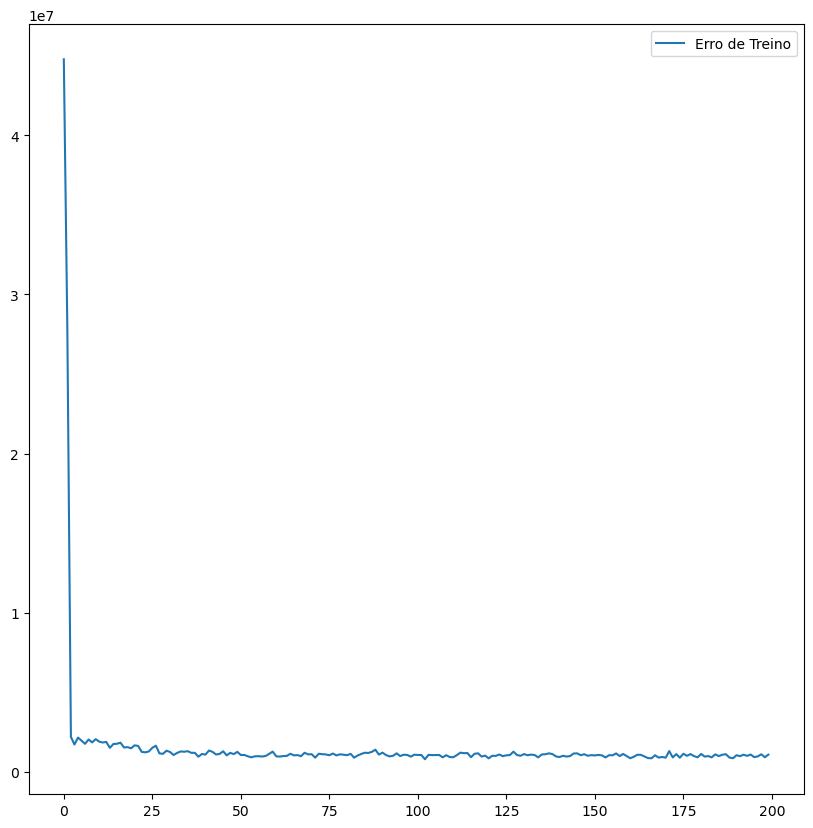

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(ret, label='Erro de Treino')
plt.legend()
plt.show()

In [ ]:
previstos = []
for i in range(len(X_test)):
    tensor = torch.tensor(X_test,dtype=torch.float32)
    with torch.no_grad():
        prev = modelFNN(tensor)

In [ ]:
print(prev.shape)

In [ ]:
real = torch.tensor(Y_test,dtype=torch.float32)
prev = torch.squeeze(prev,dim=1)
print(prev.shape)

In [ ]:

results = pd.DataFrame({'prev':prev,
                       'real':real})

In [ ]:
results['dif'] = results['real']- results['prev']

In [ ]:
results['dif'] = results['dif'].apply(np.absolute)

In [ ]:
results['dif'].mean()

In [ ]:
import seaborn as sns
sns.boxplot(results['dif'])

In [ ]:
class VAautoencoder(nn.Module):
    def __init__(self,input_dim,h_dim,z_dim):
        super().__init__()
        #encoder
        self.entrada = nn.Linear(input_dim,h_dim)
        self.sigma = nn.Linear(h_dim,z_dim)
        self.mu = nn.Linear(h_dim,z_dim)

        #decode
        self.z_2hidden = nn.Linear(z_dim,h_dim)
        self.output = nn.Linear(h_dim,input_dim)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self,x):
        h = self.relu(self.entrada(x))
        mu = self.mu(h)
        sigma = self.sigma(h)
        return mu ,sigma
    
    def decode(self,z):
        h = self.relu(self.z_2hidden(z))
        output = self.sigmoid(self.output(h))
        return output
    
    def forward(self,x):
        mu,sigma = self.encode(x)
        epsilon = torch.rand_like(sigma)
        z_reparametrizado = mu + sigma*epsilon
        x_reconstruido = self.decode(z_reparametrizado)
        return x_reconstruido,mu,sigma
        

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMPUT_DIM = 14
H_DIM = 10
Z_DIM = 7
NUM_EPOCH = 10
LA_RATE = 3e-4

In [ ]:
model = VAautoencoder(IMPUT_DIM,H_DIM,Z_DIM)
optimizer = torch.optim.Adam(model.parameters(),lr=LA_RATE)
loss_func = nn.MSELoss()
loss_per_epoch = np.zeros(NUM_EPOCH)

In [ ]:

def train_model(model,optimizer,loss_func,NUM_EPOCH,population,loss_per_epoch):
    for epoch in range(NUM_EPOCH):
        for index, x in enumerate(population):
            
            x_reconstructed, mu, sigma = model(x)
            recons_loss= loss_func(x_reconstructed,x)
            kl_div = -0.5*torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
            
            optimizer.zero_grad() 
            loss_val = recons_loss + kl_div
            loss_val.backward()
            optimizer.step()
            
            loss_per_epoch[epoch] = loss_val 
            
            
            
        print(f"Epoch {epoch}, Erro Treino: {loss_per_epoch[epoch]}")
            
            

In [ ]:
pop = torch.tensor(chromossomes,dtype=torch.float)
print(type(pop))

In [ ]:

train_model(model,optimizer,loss_func,NUM_EPOCH,pop,loss_per_epoch)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(loss_per_epoch, label='Erro de Treino')
plt.legend()
plt.show()

In [ ]:
print(fitness.argmin())

In [ ]:
print(chromossomes[8141])

In [ ]:
tensor_min = torch.tensor(chromossomes[8141],dtype=torch.float)
new_pop = []
for i in np.arange(5):
    mu,sigma = model.encode(tensor_min)
    eps = torch.rand_like(sigma)
    z = mu + sigma*eps
    out = model.decode(z)
    new_pop.append(out)

In [ ]:
new_pop_fit = []
for element in new_pop:
    fit  =decoder.decode(element)
    new_pop_fit.append(fit)
print(new_pop_fit)